In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-12-30 10:07:59.888875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 10:07:59.970997: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-30 10:07:59.974252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 10:07:59.974260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
dataset_name = 'scMultiSim-1250'
dataset_color = 'teal'
modality_names = ['Modality 1', 'Modality 2']
data_folder = '../data/scMultiSim/new/'
data1 = np.loadtxt(data_folder + "scMultiSim_RNA_counts_1250_genes.csv", delimiter=",", skiprows=1)
data2 = np.loadtxt(data_folder + "scMultiSim_ATAC_seq_1250_genes_new.csv", delimiter=",", skiprows=1)
ct = pd.read_csv(data_folder + "cell_meta_1250_genes.csv").iloc[3, 1:].to_numpy().astype(int)
type1 = type2 = np.array([f'Cell Type {i}' for i in ct])

# Labels
labels = [type1, type2]
features = [None, None]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
###
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str) and False:
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0025  Rec: 1.1084  CosSim: 0.0669  F: 0.0054
Epoch: 200 - KL: 0.0040  Rec: 0.9321  CosSim: 0.0375  F: 0.0052
Epoch: 300 - KL: 0.0064  Rec: 0.8628  CosSim: 0.0319  F: 0.0054
Epoch: 400 - KL: 0.0090  Rec: 0.8166  CosSim: 0.0298  F: 0.0053
Epoch: 500 - KL: 0.0143  Rec: 0.7929  CosSim: 0.0271  F: 0.0052
epoch:[500/10000]: loss:0.839573
Epoch: 600 - KL: 0.0170  Rec: 0.7661  CosSim: 0.0248  F: 0.0046
Epoch: 700 - KL: 0.0279  Rec: 0.7453  CosSim: 0.0251  F: 0.0044
Epoch: 800 - KL: 0.0437  Rec: 0.7315  CosSim: 0.0250  F: 0.0047
Epoch: 900 - KL: 0.0384  Rec: 0.7200  CosSim: 0.0256  F: 0.0044
Epoch: 1000 - KL: 0.0732  Rec: 0.7135  CosSim: 0.0264  F: 0.0044
epoch:[1000/10000]: loss:0.817421
Epoch: 1100 - KL: 0.0787  Rec: 0.7092  CosSim: 0.0291  F: 0.0044
Epoch: 1200 - KL: 0.1102  Rec: 0.7003  CosSim: 0.0314  F: 0.0045
Epoch: 1300 - KL: 0.1421  Rec: 0.6863  CosSim: 0.0354  F: 0.0047
Epoch: 1400 - KL: 0.1302  Rec: 0.6853  CosSim: 0.0388  F: 0.0047
Epoch: 1500 - KL: 0.1455  Rec: 0

In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0025  Rec: 1.0973  CosSim: 0.0659  F: 0.0059
Epoch: 200 - KL: 0.0041  Rec: 0.9165  CosSim: 0.0355  F: 0.0056
Epoch: 300 - KL: 0.0067  Rec: 0.8366  CosSim: 0.0296  F: 0.0054
Epoch: 400 - KL: 0.0102  Rec: 0.7886  CosSim: 0.0288  F: 0.0056
Epoch: 500 - KL: 0.0151  Rec: 0.7631  CosSim: 0.0268  F: 0.0051
epoch:[500/10000]: loss:0.810151
Epoch: 600 - KL: 0.0165  Rec: 0.7279  CosSim: 0.0245  F: 0.0048
Epoch: 700 - KL: 0.0270  Rec: 0.7221  CosSim: 0.0243  F: 0.0049
Epoch: 800 - KL: 0.0382  Rec: 0.7083  CosSim: 0.0246  F: 0.0048
Epoch: 900 - KL: 0.0462  Rec: 0.6950  CosSim: 0.0264  F: 0.0051
Epoch: 1000 - KL: 0.0698  Rec: 0.6662  CosSim: 0.0272  F: 0.0047
epoch:[1000/10000]: loss:0.767924
Epoch: 1100 - KL: 0.0850  Rec: 0.6531  CosSim: 0.0293  F: 0.0050
Epoch: 1200 - KL: 0.1077  Rec: 0.6627  CosSim: 0.0325  F: 0.0051
Epoch: 1300 - KL: 0.1393  Rec: 0.6495  CosSim: 0.0345  F: 0.0051
Epoch: 1400 - KL: 0.1287  Rec: 0.6487  CosSim: 0.0425  F: 0.0053
Epoch: 1500 - KL: 0.1452  Rec: 0

In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.0043 alpha:0.0774
epoch:[1000/2000] err:16.3444 alpha:0.1053
epoch:[1500/2000] err:18.7388 alpha:0.1709
epoch:[2000/2000] err:21.0007 alpha:0.4030
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 500, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0026  Rec: 1.0830  CosSim: 0.0688  F: 0.0094
Epoch: 200 - KL: 0.0040  Rec: 0.9191  CosSim: 0.0295  F: 0.0071
Epoch: 300 - KL: 0.0065  Rec: 0.8341  CosSim: 0.0285  F: 0.0071
Epoch: 400 - KL: 0.0094  Rec: 0.8006  CosSim: 0.0270  F: 0.0069
Epoch: 500 - KL: 0.0122  Rec: 0.7584  CosSim: 0.0238  F: 0.0061
epoch:[500/10000]: loss:0.800537
Epoch: 600 - KL: 0.0159  Rec: 0.7415  CosSim: 0.0241  F: 0.0062
Epoch: 700 - KL: 0.0264  Rec: 0.7326  CosSim: 0.0251  F: 0.0061
Epoch: 800 - KL: 0.0399  Rec: 0.6996  CosSim: 0.0234  F: 0.0060
Epoch: 900 - KL: 0.0408  Rec: 0.6738  CosSim: 0.0250  F: 0.0058
Epoch: 1000 - KL: 0.0683  Rec: 0.6581  CosSim: 0.0258  F: 0.0060
epoch:[1000/10000]: loss:0.758100
Epoch: 1100 - KL: 0.0812  Rec: 0.6710  CosSim: 0.0280  F: 0.0060
Epoch: 1200 - KL: 0.0834  Rec: 0.6643  CosSim: 0.0318  F: 0.0060
Epoch: 1300 - KL: 0.1198  Rec: 0.6329  CosSim: 0.0350  F: 0.0066
Epoch: 1400 - KL: 0.1277  Rec: 0.6232  CosSim: 0.0371  F: 0.0060
Epoch: 1500 - KL: 0.1479  Rec: 0

In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (400, 1250)
Dataset 1: (400, 3750)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:13.1823 alpha:0.1030
epoch:[1000/2000] err:13.5528 alpha:0.2266
epoch:[1500/2000] err:16.9947 alpha:0.5188
epoch:[2000/2000] err:18.5695 alpha:0.8820
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 400, found 512, adjusting to compensate.
  warnings.warn(
/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 400, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0018  Rec: 1.1413  CosSim: 0.0996  F: 0.0060
Epoch: 200 - KL: 0.0036  Rec: 0.9894  CosSim: 0.0513  F: 0.0057
Epoch: 300 - KL: 0.0059  Rec: 0.9219  CosSim: 0.0437  F: 0.0061
Epoch: 400 - KL: 0.0096  Rec: 0.8771  CosSim: 0.0377  F: 0.0055
Epoch: 500 - KL: 0.0148  Rec: 0.8487  CosSim: 0.0356  F: 0.0054
epoch:[500/10000]: loss:0.904516
Epoch: 600 - KL: 0.0217  Rec: 0.8189  CosSim: 0.0353  F: 0.0055
Epoch: 700 - KL: 0.0222  Rec: 0.8097  CosSim: 0.0349  F: 0.0053
Epoch: 800 - KL: 0.0403  Rec: 0.7788  CosSim: 0.0329  F: 0.0056
Epoch: 900 - KL: 0.0540  Rec: 0.7626  CosSim: 0.0339  F: 0.0053
Epoch: 1000 - KL: 0.0618  Rec: 0.7576  CosSim: 0.0372  F: 0.0052
epoch:[1000/10000]: loss:0.861789
Epoch: 1100 - KL: 0.0923  Rec: 0.7525  CosSim: 0.0389  F: 0.0051
Epoch: 1200 - KL: 0.0901  Rec: 0.7397  CosSim: 0.0395  F: 0.0054
Epoch: 1300 - KL: 0.1202  Rec: 0.7281  CosSim: 0.0413  F: 0.0056
Epoch: 1400 - KL: 0.1291  Rec: 0.7183  CosSim: 0.0420  F: 0.0057
Epoch: 1500 - KL: 0.1679  Rec: 0

# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [14]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [15]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [16]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

2022-12-30 10:34:13.291050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-30 10:34:13.291500: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-30 10:34:13.291529: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2022-12-30 10:34:13.292303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 10:34:13.298302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:

In [17]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1250)
Dataset 1: (500, 3750)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:82.0074 alpha:9.8663
epoch:[200/2000] err:10.9873 alpha:1.3219
epoch:[300/2000] err:8.3727 alpha:0.8845
epoch:[400/2000] err:6.8403 alpha:1.0824
epoch:[500/2000] err:5.3734 alpha:1.3768
epoch:[600/2000] err:4.6431 alpha:1.6009
epoch:[700/2000] err:4.3510 alpha:1.7600
epoch:[800/2000] err:4.2306 alpha:1.8822
epoch:[900/2000] err:4.1723 alpha:1.9834
epoch:[1000/2000] err:4.1448 alpha:2.0721
epoch:[1100/2000] err:4.1387 alpha:2.1516
epoch:[1200/2000] err:4.1476 alpha:2.2222
epoch:[1300/2000] err:4.1601 alpha:2.2853
epoch:[1400/2000] err:4.1672 alpha:2.3420
epoch:[1500/2000] err:4.1494 alpha:2.3936
epoch:[1600/2000] err:4.0735 alpha:2.4429
epoch:[1700/2000] err:3.9615 alpha:2.4892
epoch:[1800/2000] err:3.8687 alpha:2.5317
epoch:[1900/2000] err:3.8164 alpha:2.5696
epoch:[2000/2000] err:

In [18]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [19]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [20]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

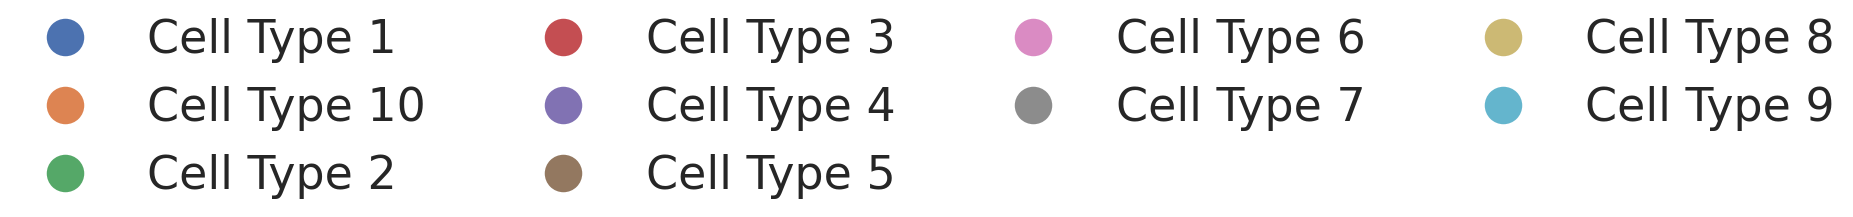

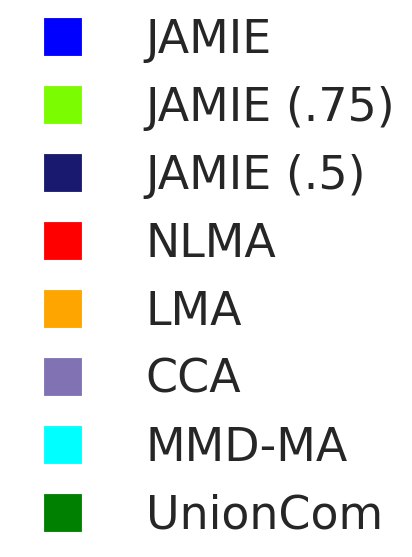

In [21]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

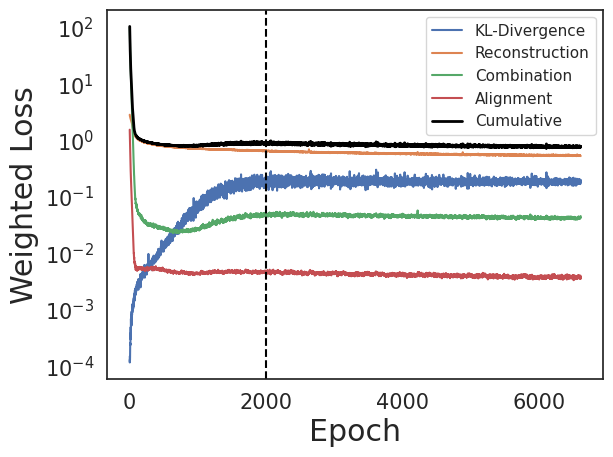

In [22]:
for k, v in jm.loss_history.items():
    loss_name = {
        'KL': 'KL-Divergence',
        'Rec': 'Reconstruction',
        'CosSim': 'Combination',
        'F': 'Alignment'
    }[k]
    plt.plot(v, label=loss_name)
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Cumulative', lw=2)
plt.axvline(x=2000, color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Weighted Loss')
plt.yscale('log')
plt.legend()
plt.savefig(image_folder + dataset_name + f'-Loss.png', dpi=300, bbox_inches='tight')

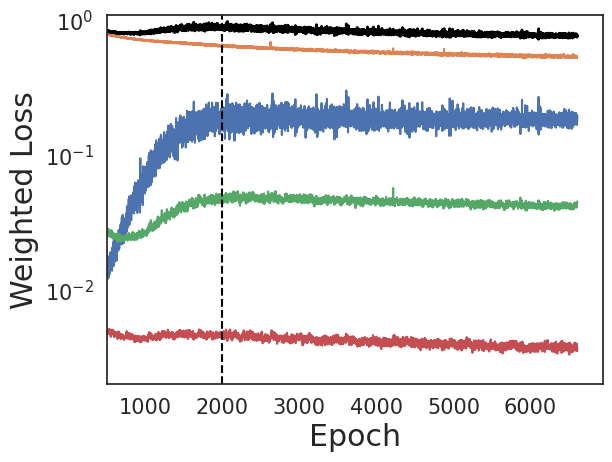

In [36]:
for k, v in jm.loss_history.items():
    loss_name = {
        'KL': 'KL-Divergence',
        'Rec': 'Reconstruction',
        'CosSim': 'Combination',
        'F': 'Alignment'
    }[k]
    plt.plot(v, label=loss_name)
total = sum(np.array(v) for k, v in jm.loss_history.items())
plt.plot(total, color='black', label='Cumulative', lw=2)
plt.axvline(x=2000, color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Weighted Loss')
plt.yscale('log')
plt.ylim([.002, 1.1])
plt.xlim([500, plt.gca().get_xlim()[1]])
plt.savefig(image_folder + dataset_name + f'-LossZoom.png', dpi=300, bbox_inches='tight')

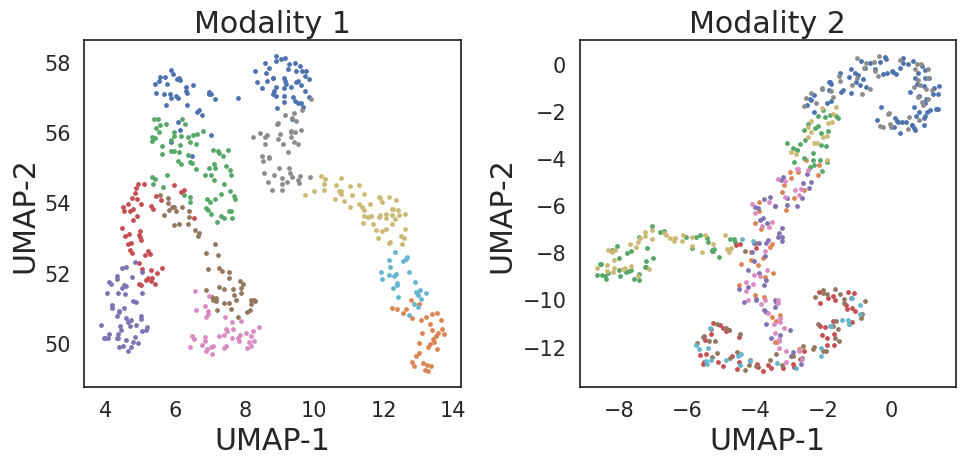

In [24]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

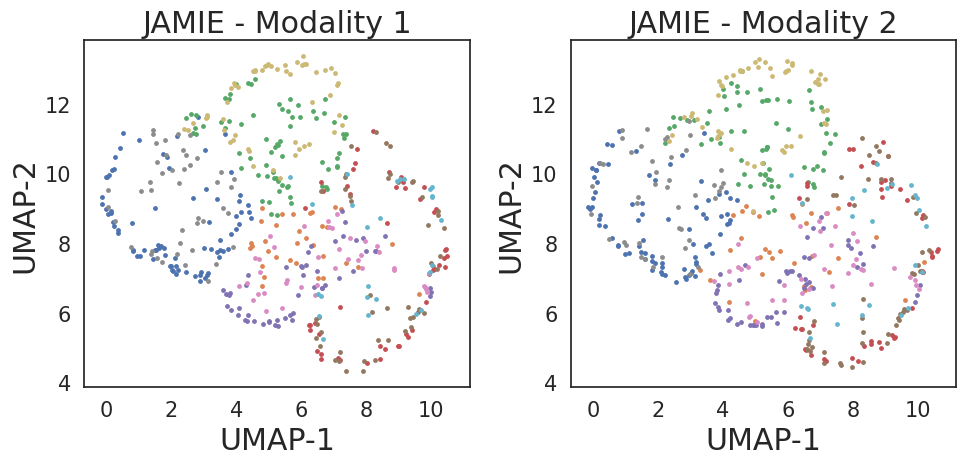

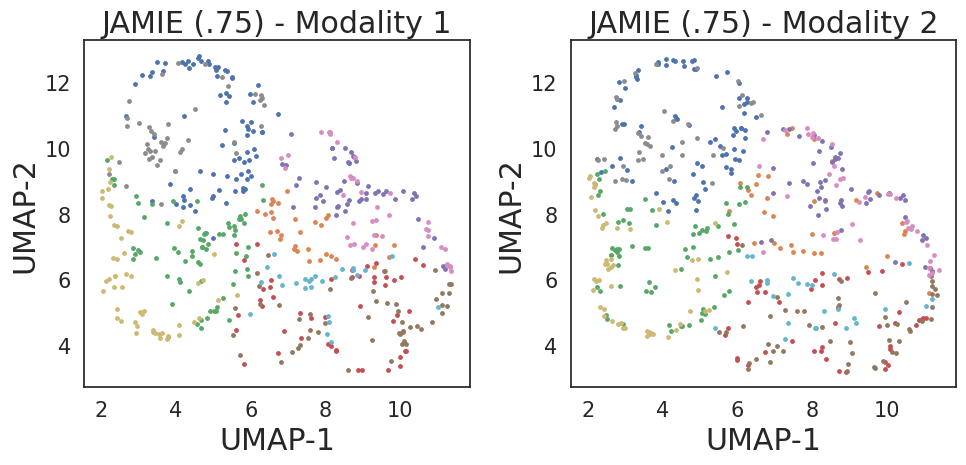

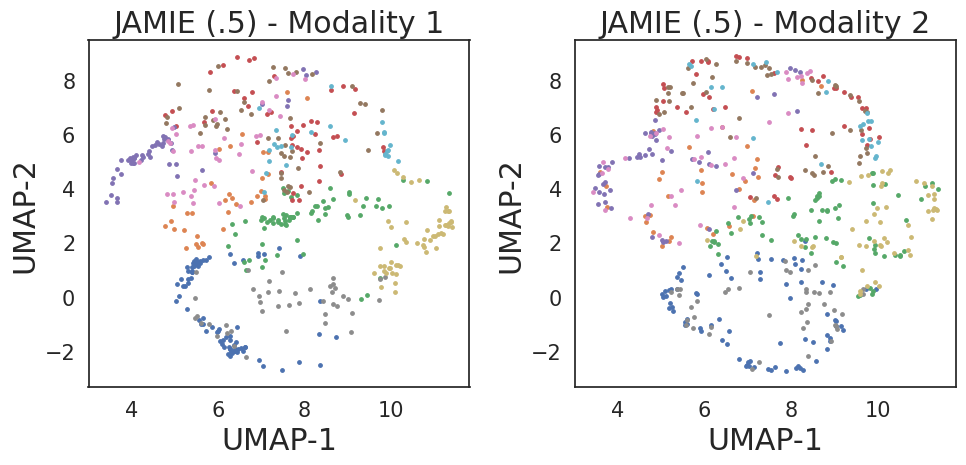

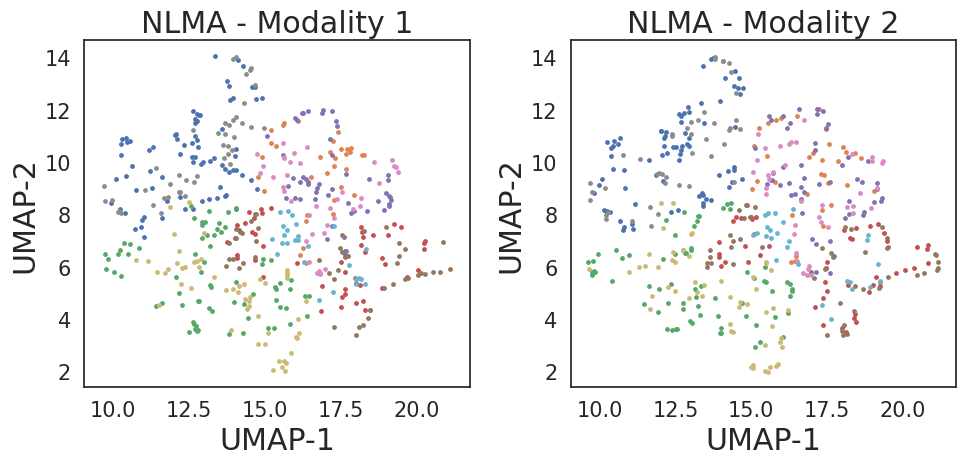

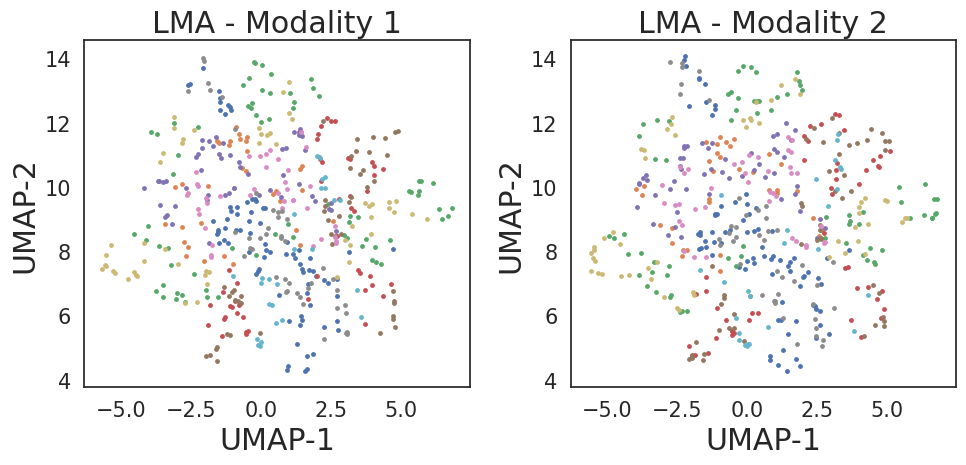

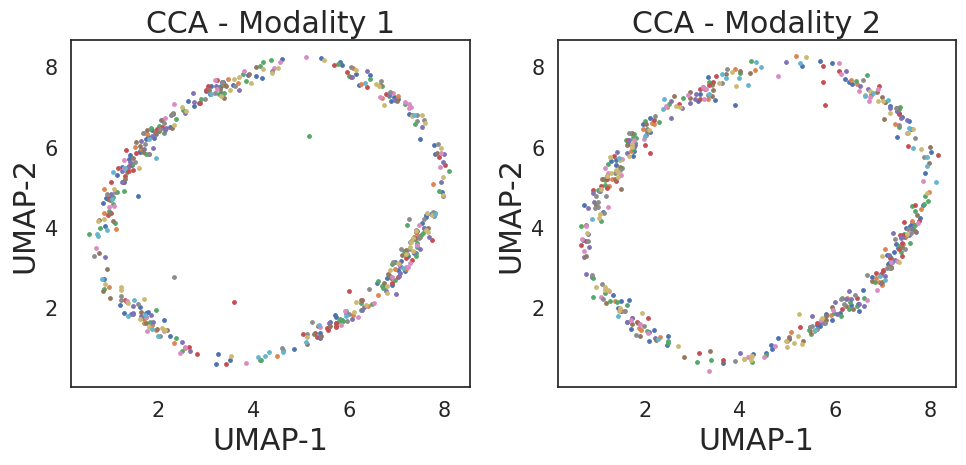

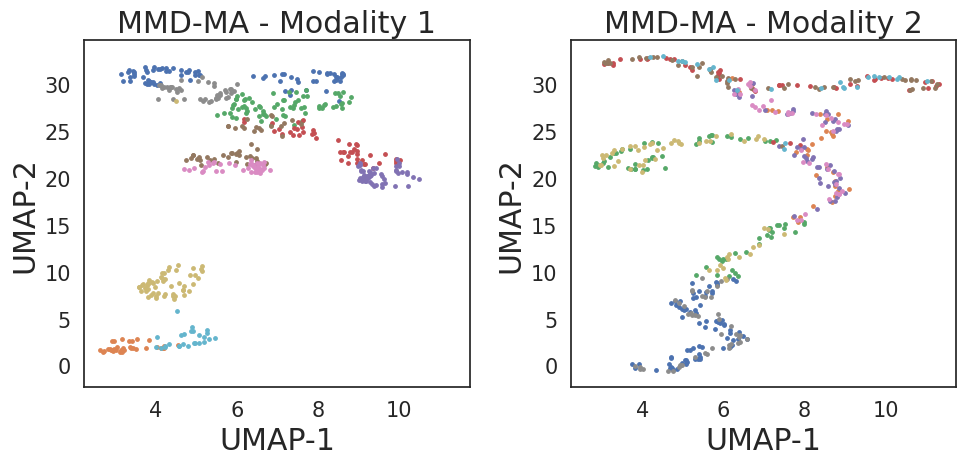

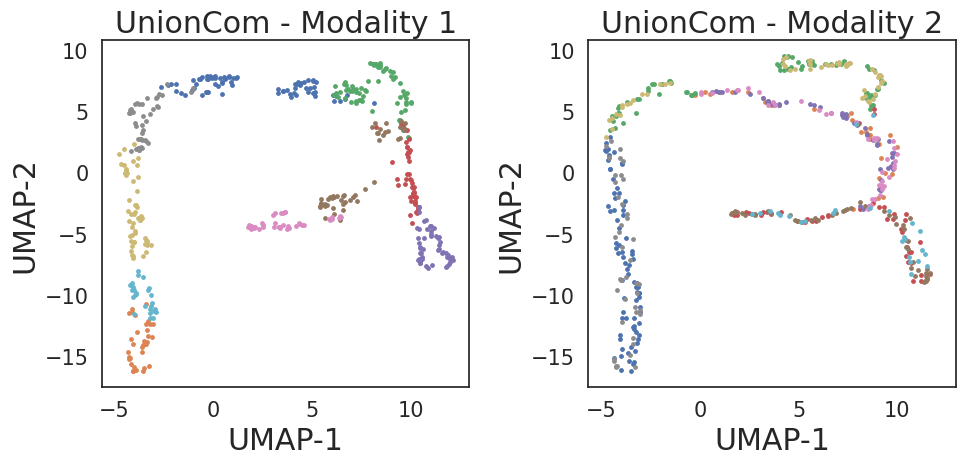

In [25]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

Algorithm    JAMIE  JAMIE (.75)  JAMIE (.5)     NLMA       LMA       CCA  \
FOSCTTM    0.00022     0.016048    0.055822  0.00194  0.001944  0.965092   
LTA        0.95200     0.890000    0.834000  0.89200  0.888000  0.140000   

Algorithm    MMD-MA  UnionCom  
FOSCTTM    0.551018  0.429574  
LTA        0.090000  0.062000  


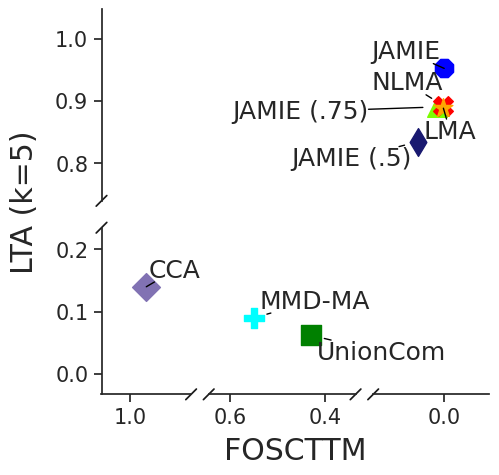

In [26]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors, shapes=shapes)
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')

In [27]:
# plt.figure(figsize=(15, 5))
# plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

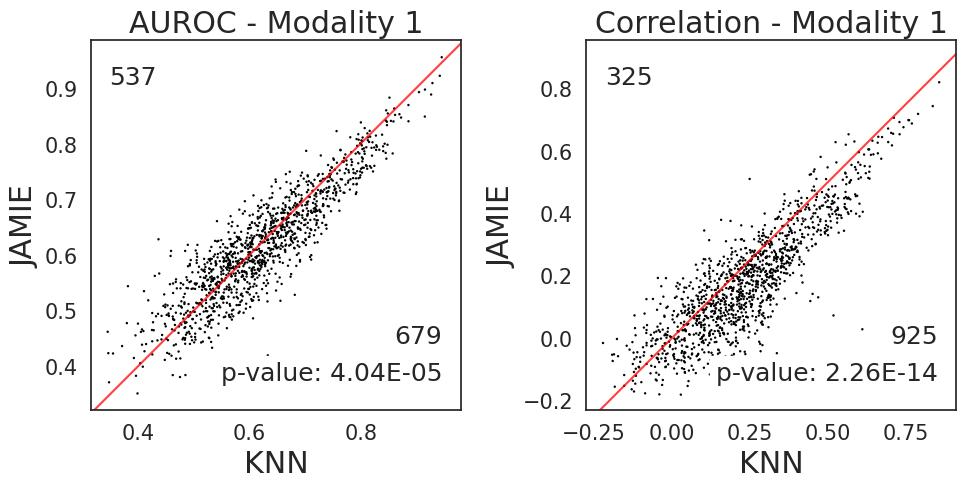

In [28]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

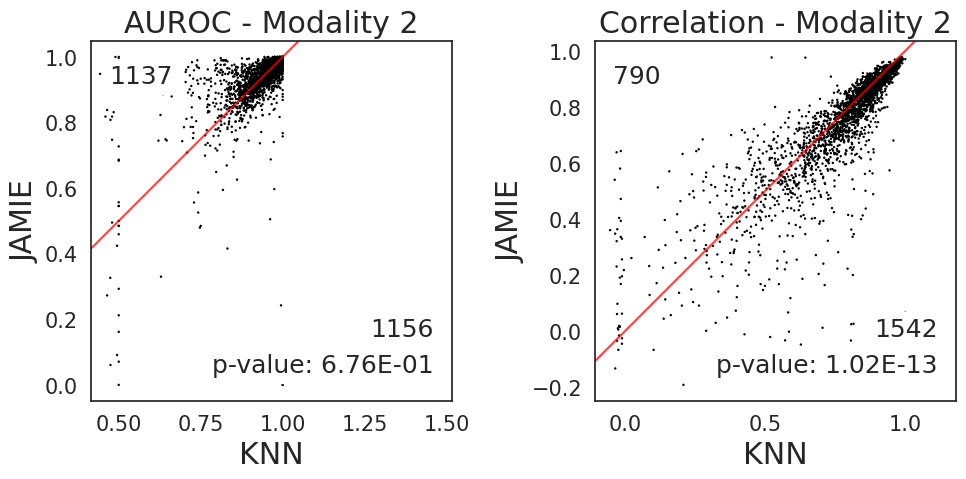

In [29]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

Feature 253: 0.3134631125039912
Feature 879: 0.2944297939864056


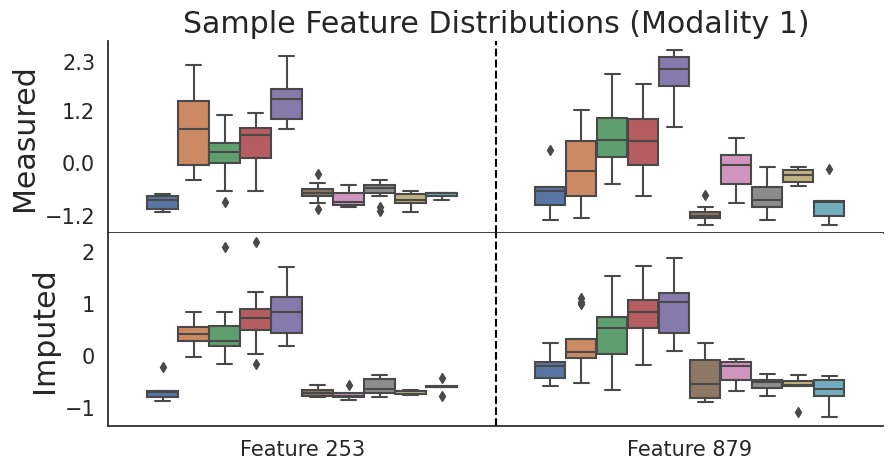

In [30]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Feature 3453: 0.1821336189573608
Feature 3512: 0.18640294661059661


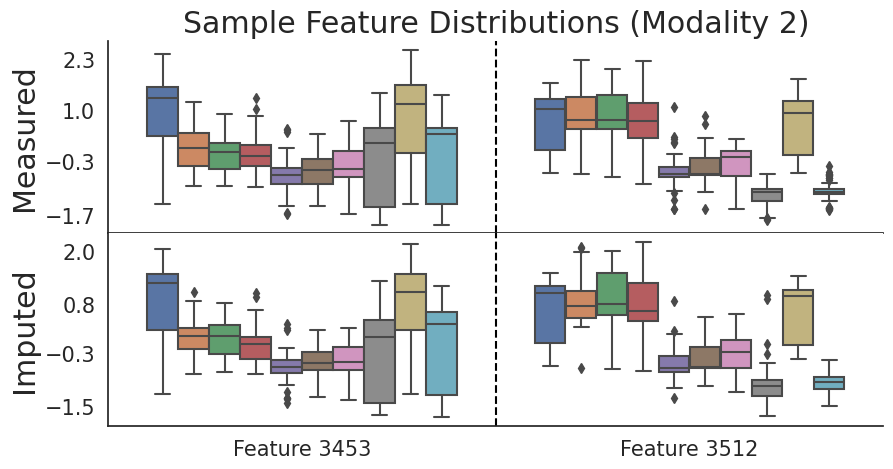

In [31]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], jm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

Mean: 0.6111086954626038
Std: 0.13179404350314514


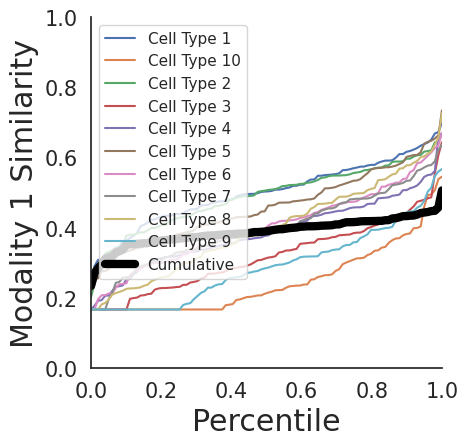

In [32]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], relative=False)
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

Mean: 0.3386301138483677
Std: 0.25231508353085796


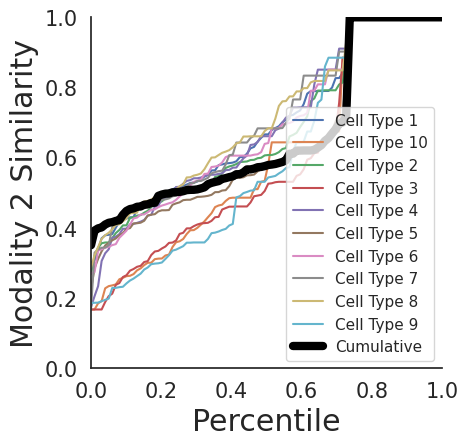

In [33]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')